# Approximate (Deep) Q-Learning
## Using TF-2
## Using Experience Replay
## Using Target Network

### Tested on CartPole-v0

##### This is another oop approach

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Start the environment
env = gym.make("CartPole-v0").env

## TF Stuff to do beforehand

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as L

In [4]:
#Checking GPU Use
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


## Create our DNN model to be used for approximating Q values

#### Currently this is just a simple model
`Input(state_dims) -> Dense(400, relu) -> Dense(400, relu) -> Dense(n_actions, linear)`

##### Subclassing allows for more complex networks, so yeah this is good

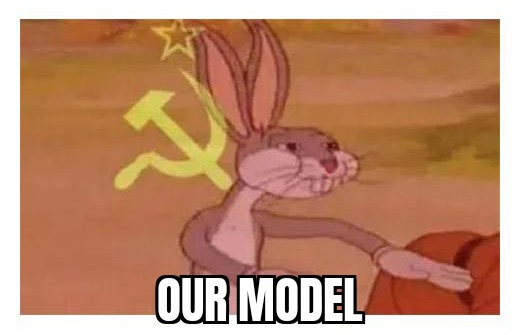

If you know you know

In [5]:
#We need to first create our custom model class
#This can be utilized for more complex networks

class OurDNN(keras.Model):
    def __init__(self, input_dim, output_dim):
        super(OurDNN, self).__init__()
        #Input layer
        self.inp = L.InputLayer(input_dim)
        #Hidden layers here - ReLu
        self.hd1 = L.Dense(64, kernel_initializer='uniform', activation='relu')
        self.hd2 = L.Dense(32, kernel_initializer='uniform', activation='relu')
        #Output layer here - linear
        self.out = L.Dense(output_dim, kernel_initializer='uniform', activation='linear')
    
    @tf.function
    def call(self, input_data):
        #Essentially feedforward your network
        inp_fwd = self.inp(input_data)
        hd1_fwd = self.hd1(inp_fwd)
        hd2_fwd = self.hd2(hd1_fwd)
        out_fwd = self.out(hd2_fwd)
        #Get the output
        return out_fwd        

## Create our AQL Agent

### The loss function for our agent is defined as - 
$$ L(w) = { 1 \over N} \sum_i (Q_{\theta}(s,a,w) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2 $$

Where
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

### The update equation is defined as
$$ \textbf{w} \leftarrow \textbf{w} + \alpha*\nabla_{\textbf w}L(\textbf w)$$

### Here we have two identical neural networks!
#### 1. Q-network which will be used to calculate $Q_{\theta}(s_t,a_t)$
#### 2. Target network which will be used to calculate  $Q_{-}(s_{t+1},a)$

This target network is updated at very target_steps time steps using the params of the Q-network - Hard Copy method

Solves the problem of error propagation in TD learning

In [6]:
class OurAgent:
    def __init__(self, env, alpha=1e-4, epsilon=0.5, gamma=0.99, buffer_size=0, target_net=False, load=False):
        
        #Set up constants
        self.state_dim = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.env = env
        self.optimizer = keras.optimizers.Adam(alpha)
        self.buffer = None
        self.target_model = None
        
        #Create the model - here, the Q-network
        if load:
            self.model = keras.models.load_model("./models/tf2_cart_model/")
            self.model.summary()
            
        else:
            self.model = OurDNN(self.state_dim, self.n_actions)
            self.model.compile(self.optimizer)
            
        #If buffer size is not 0
        if buffer_size:
            self.buffer = ReplayBuffer(buffer_size)
            print("LOG: Using Experience Replay")   
        
        #If using target networks
        if target_net:
            #If loaded q-network, then directly load
            if load:
                #Doing this since I had trouble with copying weights
                #from a pretrained model
                self.target_model = keras.models.load_model("./models/tf2_cart_model/")
            #In case it is new
            else:
                self.target_model = OurDNN(self.state_dim, self.n_actions)
                self.target_model.compile(self.optimizer)
                self.q_to_target()
            print("LOG: Using Target Network")
        
    def get_action(self, state):
        '''
        Uses E-greedy policy to get the agent action
        '''
        #Approximate the q_values
        q_values = self.model.predict(state[None])[0]
        #Explore or exploit
        ore_or_oit = np.random.choice([0,1], p =[self.epsilon, 1-self.epsilon])
        #If wanna explore
        if ore_or_oit == 0:
            chosen_action = np.random.choice(self.n_actions, 1)[0] #Over uniform dist
        #If wanna exploit
        else:
            chosen_action = np.argmax(q_values)
            
        return chosen_action

    def q_to_target(self):
        '''
        Copy Q-network weights to Target-network
        '''
        self.target_model.set_weights(self.model.get_weights())
    
    def get_loss(self, state, action, next_state, reward, is_done):
        '''
        Get the loss function as defined above
        '''
        #Get 𝑄𝜃(s,a) using actual model
        pred_q = self.model(np.atleast_2d(state.astype('float32')))
        pred_q_for_a = tf.reduce_sum(pred_q * tf.one_hot(action, self.n_actions), axis=1)
        
        #Get Q_(s',a') using the target network
        pred_next_q = self.target_model(np.atleast_2d(next_state.astype('float32')))
        #Get V_(s',a') using Q
        next_v = tf.math.reduce_max(pred_next_q, axis=1)
        #Get target Q-value, Q_(s',a')
        target_q_for_a = reward + self.gamma*next_v
        # at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
        target_q_for_a = tf.where(is_done, reward, target_q_for_a)
        
        #Calculate loss
        #Stop gradient is not required since we only update Q-net
        loss = (pred_q_for_a - target_q_for_a) ** 2
        loss = tf.reduce_mean(loss)
        
        return loss
        
    def train_step(self, state, action, next_state, reward, is_done):
        '''
        Trains the network
        '''
        #Variables to train - here weight
        variables = self.model.trainable_variables
        
        #Perform semi-grad Q Learning with Adam optimizer
        with tf.GradientTape() as tape:
            loss = self.get_loss(state, action, next_state, reward, is_done)
            gradients = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(gradients, variables))
     
    def generate_session(self, t_max=1000, train=False, batch_size=32, target_steps=100):
        '''
        Run environment and train
        '''
        total_reward = 0
        s = self.env.reset()
        
        for t in range(t_max):
            a = self.get_action(s)
            next_s, r, done, _ = self.env.step(a)
            
            if train:
                self.train_step(s, a, next_s, r, done)
                
                #If using exp replay to learn
                if self.buffer is not None:
                    data = (s, a, r, next_s, done)
                    self.buffer.add(*data)
                    #Sample transitions and update
                    s_,a_,r_,next_s_,done_ = self.buffer.sample(batch_size)
                    for i in range(batch_size):
                        self.train_step(s_[i],
                                        a_[i], 
                                        next_s_[i],
                                        r_[i],
                                        done_[i])
                
                #If using target_networks and after target_steps time
                if (t%target_steps==0) and (self.target_model is not None):
                    #Copy weights to target
                    self.q_to_target()
            
            total_reward += r
            s = next_s
            if done:
                break
        
        return total_reward
    
    def save(self):
        self.model.save("./models/tf2_cart_model2", save_format="tf")

## Create Experience Replay Buffer using deque

In [7]:
from collections import deque
#Deque has a better time complexity

class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        """
        self._storage = deque(maxlen=size)
        self._maxsize = size

    def __len__(self):
        return len(self._storage)
    
    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Add new elements into the FIFO buffer
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        #FIFO check not really required since dequeu checks it
        #Now append the data
        self._storage.append(data)
    
    def sample(self, batch_size):
        """
        Sample a batch of experiences.
        """
        #Sample random indexes from the buffer
        idxes = np.random.randint(len(self._storage), size=batch_size)

        #First convert the data to numpy array
        np_storage = np.array(self._storage)
        
        #Now use these indexes to get the samples
        samples = np_storage[idxes]
        #Return corresponding values
        return(
#             np.stack(samples[:,0]),
            samples[:,0],
            samples[:,1],
            samples[:,2],
#             np.stack(samples[:,3]),
            samples[:,3],
            samples[:,4]
        )

In [10]:
#Agent using cartpole environment and Adam optimizer
agent = OurAgent(env, buffer_size=1024, target_net=True)

LOG: Using Experience Replay
LOG: Using Target Network


Stopped
epoch #9	mean reward = 20.400	epsilon = 0.457


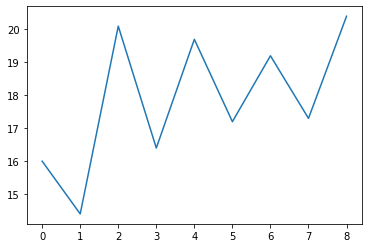

INFO:tensorflow:Assets written to: ./models/tf2_cart_model2/assets


In [11]:
from IPython.display import clear_output

mean_rewards = []
max_reward = 0
try:
    for i in range(1000):
        session_rewards = [agent.generate_session(train=True) for _ in range(10)]
        mean_rewards.append(np.mean(session_rewards))
        agent.epsilon *= 0.99
        clear_output(True)
        print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
        plt.plot(mean_rewards)
        plt.show()
        #Save weights for new best weights
        if mean_rewards[i] > max_reward:
                max_reward = mean_rewards[i]
                agent.save()
        if np.mean(session_rewards) > 300:
            print("You Win! Stop using Keyboard Interrupt")
    #         break

except KeyboardInterrupt:
    clear_output(True)
    print("Stopped")
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), agent.epsilon))
    plt.plot(mean_rewards)
    plt.show()
    agent.save()

In [9]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    agent.env = env_monitor
    agent.epsilon = 0
    sessions = [agent.generate_session(train=False) for _ in range(10)]
    print(sessions)

[200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]


In [10]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices